In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../output/features_summary.csv")

In [4]:
print(df.head())
print(df.columns.to_list())

  instrument       rms  attack_time_s  hnr_proxy_db  tempo_est_bpm  \
0       bass  0.092586       0.044807           NaN      30.046330   
1      piano  0.100000       0.060136           NaN      30.046330   
2      flute  0.100000       0.268617           NaN      30.046330   
3      drums  0.099985       0.050839           NaN      30.046330   
4    trumpet  0.100000       0.072698           NaN      99.384014   

   onset_rate_s  centroid_mean  centroid_std  centroid_median  bandwidth_mean  \
0           0.6     556.528988    557.402521       484.288977     1068.783124   
1           0.6     807.115484    211.608603       803.527365      840.346151   
2           3.8     549.765387    278.278799       515.928844      763.265015   
3           0.6     728.921332    859.336696       458.974708     1433.563945   
4           0.6    2297.899919    117.539644      2281.265667     1608.884124   

   ...  chroma2_mean  chroma3_mean  chroma4_mean  chroma5_mean  chroma6_mean  \
0  ...      

In [5]:
df_summary = df.groupby("instrument").mean(numeric_only=True)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
print(df_summary.T)

instrument      bass  drums  flute  piano  trumpet
rms            0.093  0.100  0.100  0.100    0.100
attack_time_s  0.045  0.051  0.269  0.060    0.073
hnr_proxy_db     NaN    NaN    NaN    NaN      NaN
tempo_est_bpm 30.046 30.046 30.046 30.046   99.384
onset_rate_s   0.600  0.600  3.800  0.600    0.600
...              ...    ...    ...    ...      ...
chroma7_mean   0.210  0.627  0.007  0.314    0.855
chroma8_mean   0.264  0.722  0.004  0.082    0.178
chroma9_mean   0.308  0.538  0.005  0.010    0.172
chroma10_mean  0.193  0.406  0.014  0.026    0.270
chroma11_mean  0.290  0.437  0.246  0.204    0.210

[64 rows x 5 columns]


In [8]:
import matplotlib.pyplot as plt
import pandas as pd


# calcular médias por instrumento
df_summary = df.groupby("instrument").mean(numeric_only=True)

# selecionar as principais features para comparação
features = [
    "rms",            # energia média (volume percebido)
    "attack_time_s",  # tempo de ataque
    "centroid_mean",  # brilho
    "rolloff_mean",   # extensão espectral
    "flatness_mean",  # ruído
    "flux_mean",      # variação espectral
    "zcr_mean"        # aspereza/brilho adicional
]

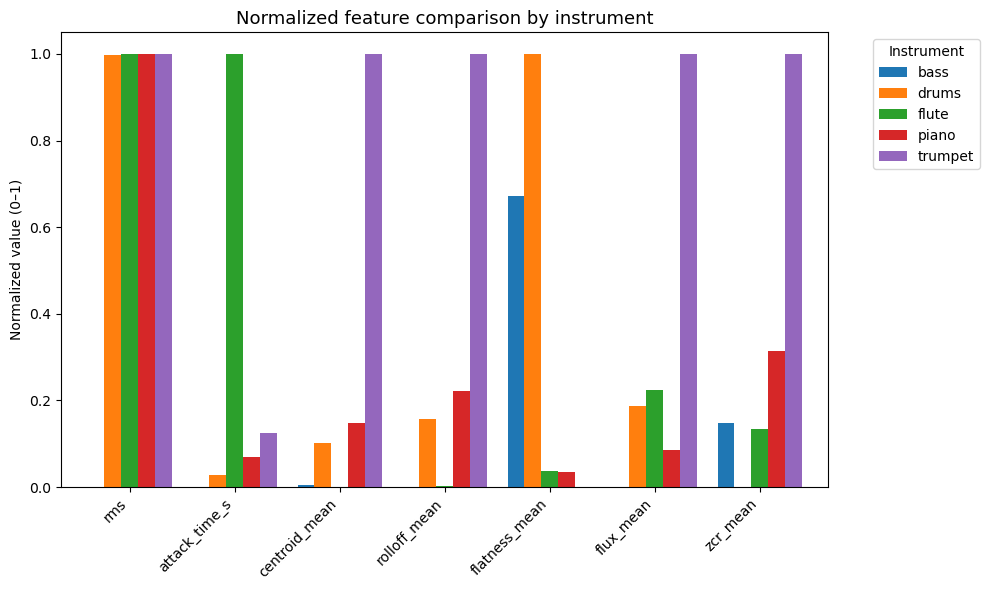

In [9]:
df_norm = (df_summary[features] - df_summary[features].min()) / \
          (df_summary[features].max() - df_summary[features].min())

df_norm.T.plot(kind="bar", figsize=(10,6), width=0.8)
plt.title("Normalized feature comparison by instrument", fontsize=13)
plt.ylabel("Normalized value (0–1)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Instrument", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

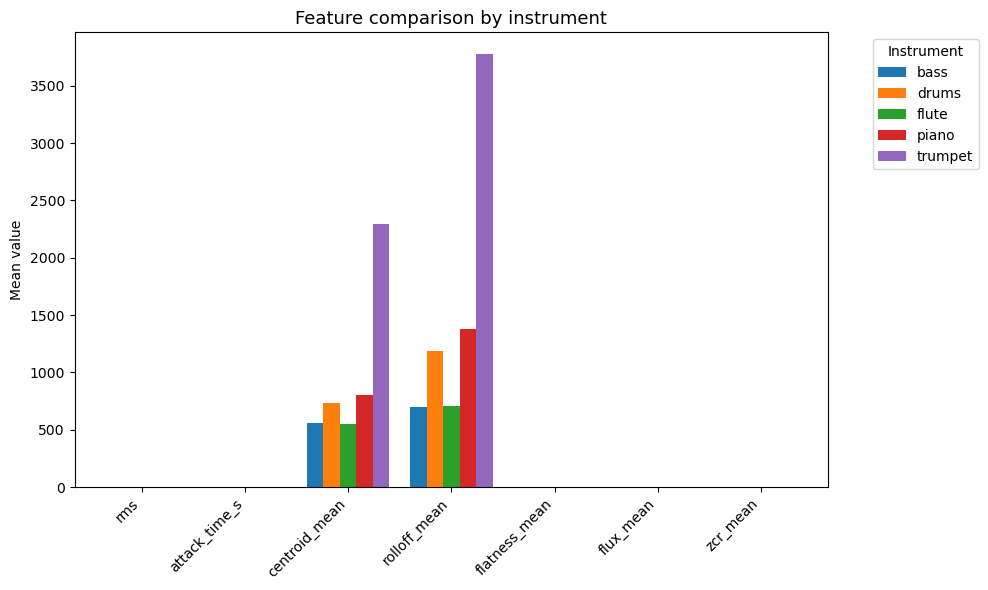

In [10]:
# plotagem
df_summary[features].T.plot(kind="bar", figsize=(10,6), width=0.8)
plt.title("Feature comparison by instrument", fontsize=13)
plt.ylabel("Mean value")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Instrument", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

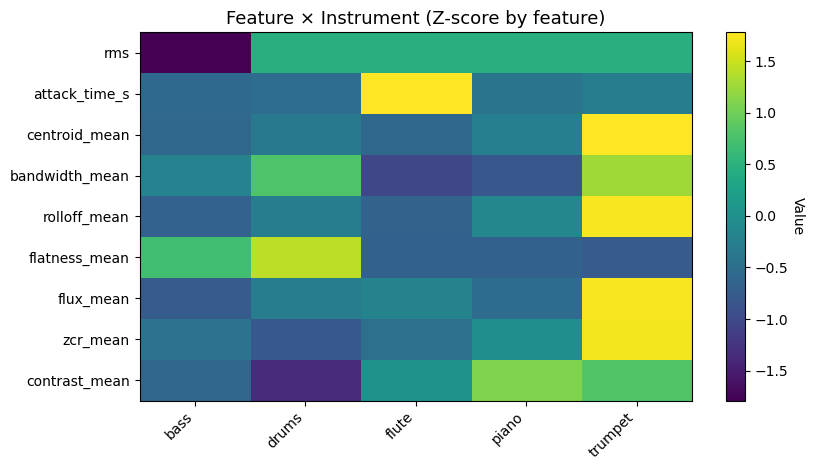

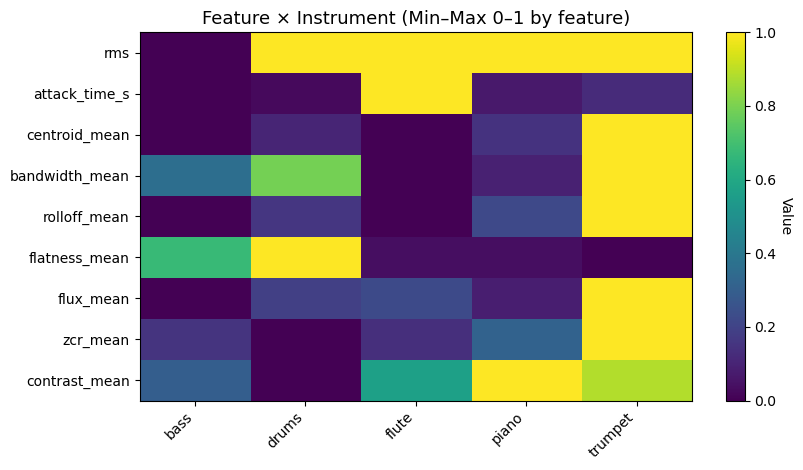


Raw means:
 instrument          bass     drums   flute     piano   trumpet
rms                0.093     0.100   0.100     0.100     0.100
attack_time_s      0.045     0.051   0.269     0.060     0.073
centroid_mean    556.529   728.921 549.765   807.115 2,297.900
bandwidth_mean 1,068.783 1,433.564 763.265   840.346 1,608.884
rolloff_mean     697.088 1,183.927 706.658 1,379.321 3,776.236
flatness_mean      0.060     0.089   0.005     0.005     0.001
flux_mean          0.258     0.644   0.717     0.433     2.314
zcr_mean           0.025     0.011   0.024     0.041     0.105
contrast_mean     24.193    20.276  27.790    33.461    31.928

Z-score by feature:
 instrument       bass  drums  flute  piano  trumpet
rms            -1.789  0.444  0.448  0.448    0.448
attack_time_s  -0.574 -0.510  1.778 -0.413   -0.281
centroid_mean  -0.583 -0.350 -0.592 -0.244    1.769
bandwidth_mean -0.201  0.789 -1.031 -0.822    1.265
rolloff_mean   -0.665 -0.285 -0.658 -0.132    1.740
flatness_mean   0.703  

In [12]:
# === Heatmap: features × instruments ===
# Comments in English, as requested.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load dataset and compute per-instrument means ---
df_summary = df.groupby("instrument").mean(numeric_only=True)

# --- Choose a compact, perceptually meaningful feature set ---
features = [
    "rms",            # perceived energy
    "attack_time_s",  # onset speed (percussiveness)
    "centroid_mean",  # brightness
    "bandwidth_mean", # spectral spread
    "rolloff_mean",   # upper-frequency extension
    "flatness_mean",  # noisiness
    "flux_mean",      # spectral change / transients
    "zcr_mean",       # additional brightness/roughness cue
    "contrast_mean"   # spectral peaks vs valleys (texture)
]

# Keep only available columns (in case one is missing)
features = [c for c in features if c in df_summary.columns]
M = df_summary[features].copy()

# --- Build two normalizations: Z-score and MinMax ---
# Z-score: highlights relative contrasts; centered per feature
M_z = (M - M.mean(axis=0)) / (M.std(axis=0) + 1e-12)

# MinMax: 0–1 per feature, more intuitive for presentation
M_min = M.min(axis=0)
M_max = M.max(axis=0)
M_mm = (M - M_min) / (M_max - M_min + 1e-12)

# --- Plot function using plain Matplotlib (no seaborn) ---
def plot_heatmap(matrix, title, cmap="viridis", fname=None):
    fig, ax = plt.subplots(figsize=(8.5, 4.8))
    im = ax.imshow(matrix.values.T, aspect="auto", cmap=cmap)
    ax.set_title(title, fontsize=13)
    ax.set_yticks(range(len(matrix.columns)))
    ax.set_yticklabels(matrix.columns, fontsize=10)
    ax.set_xticks(range(len(matrix.index)))
    ax.set_xticklabels(matrix.index, rotation=45, ha="right", fontsize=10)
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Value", rotation=270, labelpad=12)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()

# --- Plot Z-score heatmap (best for spotting contrasts) ---
plot_heatmap(M_z, title="Feature × Instrument (Z-score by feature)", fname="heatmap_features_zscore.png")

# --- Plot MinMax heatmap (0–1; best for slides) ---
plot_heatmap(M_mm, title="Feature × Instrument (Min–Max 0–1 by feature)", fname="heatmap_features_minmax.png")

# (Optional) print the underlying tables for quick inspection
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
print("\nRaw means:\n", M.T)
print("\nZ-score by feature:\n", M_z.T)
print("\nMin–Max [0–1] by feature:\n", M_mm.T)
